In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import shap

In [2]:
pitches = pd.read_csv("2024pitches.csv")
pitch_clusters = pd.read_csv("pitch_clusters.csv")
pd.set_option('display.max_columns', None)
pitches.head()


,Unnamed: 0,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
0,0,1669,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",687637,682791,single,hit_into_play,NaN,NaN,NaN,NaN,NaN,Dylan Beavers singles on a soft ground ball to...,S,L,R,BAL,BOS,X,1.0,ground_ball,1,0,2024,NaN,NaN,NaN,NaN,682983.0,642021.0,NaN,2,9,Bot,118.13,186.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,0.9,NaN,1.0,0.0,NaN,75,2,NaN,4,4,4,4,4,5,5,4,NaN,NaN,NaN,0.370,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.630,0.630,22,22,23,23,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1736,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",687637,682791,NaN,ball,NaN,NaN,NaN,NaN,NaN,Dylan Beavers singles on a soft ground ball to...,S,L,R,BAL,BOS,B,NaN,NaN,0,0,2024,NaN,NaN,NaN,NaN,682983.0,NaN,642021.0,2,9,Bot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,1,NaN,4,4,4,4,4,4,4,4,NaN,NaN,NaN,-0.005,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.635,0.635,22,22,23,23,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1880,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",642021,682791,walk,ball,NaN,NaN,NaN,NaN,NaN,Errol Robinson walks.,S,R,R,BAL,BOS,B,NaN,NaN,3,0,2024,NaN,NaN,NaN,NaN,682983.0,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,0.7,NaN,0.0,0.0,NaN,74,4,NaN,4,4,4,4,4,4,4,4,NaN,NaN,NaN,0.007,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.628,0.628,22,29,23,30,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2002,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",642021,682791,NaN,ball,NaN,NaN,NaN,NaN,NaN,Errol Robinson walks.,S,R,R,BAL,BOS,B,NaN,NaN,2,0,2024,NaN,NaN,NaN,NaN,682983.0,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74,3,NaN,4,4,4,4,4,4,4,4,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.628,0.628,22,29,23,30,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2156,NaN,2024-03-16,NaN,NaN,NaN,"Jackson, Gabriel",642021,682791,NaN,ball,NaN,NaN,NaN,NaN,NaN,Errol Robinson walks.,S,R,R,BAL,BOS,B,NaN,NaN,1,0,2024,NaN,NaN,NaN,NaN,682983.0,NaN,NaN,2,9,Bot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747948,656627,694359,642197,656388,686765,681468,694812,676628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74,2,NaN,4,4,4,4,4,4,4,4,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0.628

In [3]:
columns = [
    "pitch_type", "release_speed", "release_pos_x", "release_pos_z", "batter", "pitcher", "events", "description", "zone",
    "des", "game_type", "stand", "p_throws", "type", "balls", "strikes", "pfx_x", "pfx_z", "plate_x", "plate_z", "on_3b",
    "on_2b", "on_1b", "hc_x", "hc_y", "sv_id", "vx0", "vy0", "vz0", "ax", "ay", "az", "sz_top", "sz_bot", "hit_distance_sc",
    "launch_speed", "launch_angle", "effective_speed", "release_spin_rate", "release_extension", "game_pk", "release_pos_y",
    "estimated_woba_using_speedangle", "launch_speed_angle", "at_bat_number", "pitch_number", "pitch_name", "home_score",
    "away_score", "spin_axis", "delta_home_win_exp", "delta_run_exp", "bat_speed", "swing_length",
    "estimated_slg_using_speedangle", "delta_pitcher_run_exp", "bat_win_exp", "n_thruorder_pitcher",
    "n_priorpa_thisgame_player_at_bat", "arm_angle"
]
pitch_data = pitches[columns]
pitch_data = pitch_data.dropna(subset=['pitch_type', 'release_speed', 'spin_axis', 'release_extension', 'effective_speed'])

pitch_clusters_long = pitch_clusters.melt(id_vars=['pitcher'], var_name='pitch_type', value_name='cluster_label')
pitch_clusters_long = pitch_clusters_long[pitch_clusters_long['cluster_label'] != -1]
pitch_data = pitch_data.merge(pitch_clusters_long, on=['pitcher', 'pitch_type'], how='left')

x_bins = np.linspace(-2, 2, num=5)  
z_bins = np.linspace(0, 4, num=5)   

pitch_data["zone_x"] = np.digitize(pitch_data["plate_x"], bins=x_bins, right=False)
pitch_data["zone_z"] = np.digitize(pitch_data["plate_z"], bins=z_bins, right=False)
pitch_data["zone"] = pitch_data["zone_x"].astype(str) + "-" + pitch_data["zone_z"].astype(str)

pitch_data_bip = pitch_data[pitch_data["description"] == "hit_into_play"].copy()

features = ["launch_angle", "launch_speed"]
target = "estimated_woba_using_speedangle"
pitch_data_bip = pitch_data_bip.dropna(subset=features + [target])


For this update, I wanted to instead look at the most common launch angle and exit velocity combinations by zone. I use KNN with launch angle and exit velocity, using xwOBA as the target. I think it may be better not to look at hitter success by pitch type AND zone, since in a season, there are many data points for each bucket, so instead, I look at the most common exit velocities and launch angles by zone for the hitters. Using this data with K-Nearest Neighbors, I add a column that describes what the KNN regression predicts the xwOBA to be for a pitch in each of the zones on the hitter level.

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pitch_data_bip[features])

knn = KNeighborsRegressor(n_neighbors=10, weights="distance")
knn.fit(X_scaled, pitch_data_bip[target])

pitch_data_bip["xwOBA_KNN"] = knn.predict(X_scaled)

zone_success = pitch_data_bip.groupby(["batter", "zone_x", "zone_z"])["xwOBA_KNN"].mean().reset_index()

pitch_type_success = pitch_data_bip.groupby(["batter", "pitch_type"])[target].mean().reset_index()
pitch_type_success.rename(columns={target: "estimated_woba_by_pitch_type"}, inplace=True)

pitch_data = pitch_data.drop(columns=["estimated_woba_using_speedangle_zone_avg"], errors="ignore")
pitch_data = pitch_data.merge(zone_success, on=["batter", "zone_x", "zone_z"], how="left")
pitch_data = pitch_data.merge(pitch_type_success, on=["batter", "pitch_type"], how="left")
pitch_data.rename(columns={"xwOBA_KNN": "estimated_woba_using_speedangle_zone_avg"}, inplace=True)


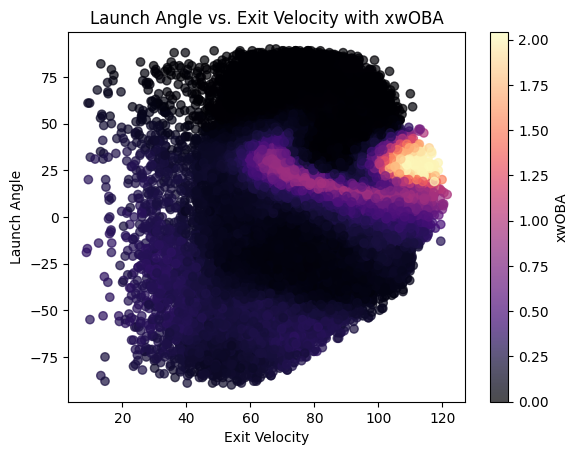

In [5]:
#plot to help visualize the K-Nearest Neighbors

pitch_data_bip = pitch_data[pitch_data["description"] == "hit_into_play"].copy()
pitch_data_bip = pitch_data_bip.dropna(subset=["launch_angle", "launch_speed"])
plt.scatter(pitch_data_bip["launch_speed"], pitch_data_bip["launch_angle"], 
            c=pitch_data_bip["estimated_woba_using_speedangle"], cmap="magma", alpha=0.7)
plt.colorbar(label="xwOBA")
plt.xlabel("Exit Velocity")
plt.ylabel("Launch Angle")
plt.title("Launch Angle vs. Exit Velocity with xwOBA")
plt.show()

In [6]:
pitch_data.sample(10)

,pitch_type,release_speed,release_pos_x,release_pos_z,batter,pitcher,events,description,zone,des,game_type,stand,p_throws,type,balls,strikes,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,hc_x,hc_y,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,release_pos_y,estimated_woba_using_speedangle,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,bat_win_exp,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,arm_angle,cluster_label,zone_x,zone_z,estimated_woba_using_speedangle_zone_avg,estimated_woba_by_pitch_type
555072,SI,90.4,-1.82,6.59,695578,592836,NaN,swinging_strike,3-4,James Wood strikes out swinging.,R,L,R,S,2,0,-1.31,0.85,0.38,3.35,682928.0,NaN,NaN,NaN,NaN,NaN,8.164818,-131.407327,-3.913633,-16.924419,26.171333,-21.675813,3.79,1.73,NaN,NaN,NaN,89.6,1915.0,5.7,745539,54.79,NaN,NaN,3,3,Sinker,0,0,215.0,0.000,-0.083,69.0,6.0,NaN,0.083,0.549,1,0,40.0,1.0,3,4,0.453652,0.365395
198038,CH,84.7,3.43,4.86,665804,519242,field_out,hit_into_play,3-3,Miguel Amaya pops out to first baseman Matt Ol...,R,R,L,X,2,1,1.22,0.21,0.90,2.55,NaN,NaN,NaN,155.21,196.67,NaN,-8.323544,-123.134240,0.552658,14.065413,23.825412,-30.404094,3.33,1.53,76.0,79.0,77.0,84.6,1644.0,6.2,747124,54.26,0.003000,3.0,39,4,Changeup,7,0,96.0,0.005,-0.265,78.0,8.0,0.003,0.265,0.019,2,1,6.0,0.0,3,3,0.345095,0.248818
495219,FF,90.3,1.53,6.38,624413,542881,walk,ball,3-4,Pete Alonso walks.,R,R,L,B,3,2,0.53,1.85,0.59,3.90,NaN,NaN,NaN,NaN,NaN,NaN,-3.462334,-131.369262,-4.104704,6.944135,30.126083,-10.126600,3.49,1.63,NaN,NaN,NaN,89.5,2226.0,6.0,746193,54.49,0.689131,NaN,39,6,4-Seam Fastball,1,3,161.0,-0.026,0.333,NaN,NaN,NaN,-0.333,0.761,3,2,57.0,2.0,3,4,0.597980,0.449087
74343,CU,80.7,-0.88,6.40,553882,623433,NaN,ball,3-1,Omar Narváez lines out to center fielder Garre...,R,L,R,B,0,0,0.37,-0.08,0.21,0.34,NaN,NaN,NaN,NaN,NaN,NaN,1.729162,-117.470094,-6.694259,3.124776,21.461956,-31.934719,3.00,1.39,NaN,NaN,NaN,80.8,1922.0,6.3,745839,54.23,NaN,NaN,67,1,Curveball,5,11,97.0,0.000,0.034,NaN,NaN,NaN,-0.034,0.017,1,2,52.0,0.0,3,1,NaN,0.221000
187598,FS,84.0,-2.03,6.13,553993,668881,NaN,ball,4-3,Eugenio Suárez pops out to first baseman Spenc...,R,R,R,B,1,0,-0.50,0.73,1.25,2.31,NaN,NaN,NaN,NaN,NaN,NaN,8.616204,-122.111103,-3.912072,-6.719399,23.750361,-24.282592,3.42,1.60,NaN,NaN,NaN,84.1,1258.0,6.4,746715,54.09,NaN,NaN,9,2,Split-Finger,0,1,222.0,0.000,0.062,NaN,NaN,NaN,-0.062,0.608,1,0,33.0,1.0,4,3,0.363406,0.606750
51932,SL,86.1,-0.79,5.94,624585,675627,NaN,swinging_strike,3-3,Jorge Soler singles on a sharp ground ball to ...,R,R,R,S,0,0,0.27,0.21,0.45,2.33,NaN,NaN,NaN,NaN,NaN,NaN,2.407749,-125.418432,-2.826731,2.442171,24.224917,-29.561668,3.63,1.76,NaN,NaN,NaN,87.0,2337.0,6.7,746169,53.82,NaN,NaN,64,1,Slider,5,4,100.0,0.000,-0.033,NaN,NaN,NaN,0.033,0.247,1,3,58.0,0.0,3,3,0.504679,0.361039
599492,CH,89.8,1.99,6.17,649966,656271,NaN,foul,3-2,Luis Urías called out on strikes.,R,R,L,S,1,2,1.04,0.32,0.35,1.90,NaN,NaN,668227.0,NaN,NaN,NaN,-6.341255,-130.583748,-5.318754,13.264636,26.586713,-27.583991,3.24,1.56,NaN,NaN,NaN,91.0,2092.0,7.0,746182,53.52,NaN,NaN,38,4,Changeup,1,4,127.0,0.000,0.000,73.0,8.0,NaN,0.000,0.847,1,2,38.0,0.0,3,2,0.333981,0.634000
523920,FF,93.2,2.30,6.04,683734,657006,NaN,foul,3-4,Andrew Vaughn walks. Lenyn Sosa to 2nd.,R,R,L,S,3,2,-0.20,1.18,0.12,3.12,NaN,NaN,672820.0,NaN,NaN,NaN,-5.156845,-135.704312,-4.393881,-1.437582,28.350847,-16.757731,3.18,1.47,280.0,93.9,21.0,93.5,2488.0,6.3,746761,54.19,NaN,NaN,9,6,4-Seam Fastball,0,0,153.0,0.000,0.000,72.0,6.0,NaN,0.000,0.522,1,0,40.0,2.0,3,4,0.351187,0.430382
14498,SL,86.2,-2.21,5.41,663757,681738,NaN,foul,2-4,Trent Grisham walks.,S,L,R,S,3,2,0.39,-0.52,-0.19,3.21,NaN,NaN,NaN,NaN,NaN,NaN,4.015829,-125.424471,2.074496,3.242436,26.977016,-38.296319,3.17,1.60,185.0,75.3,58.0,86.0,25

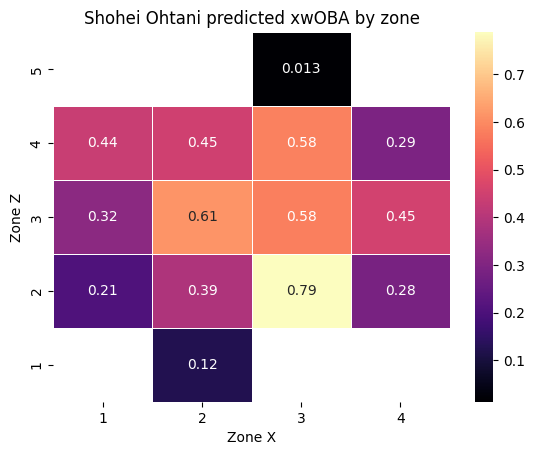

In [7]:
#For an example, here are the xwOBA predictions by zone for Shohei Ohtani given his launch angle and exit velocity data

ohtani_data = pitch_data[pitch_data["batter"] == 660271]
pivot_table = ohtani_data.pivot_table(
    values="estimated_woba_using_speedangle_zone_avg",
    index="zone_z",
    columns="zone_x",
    aggfunc="mean")

sns.heatmap(pivot_table, annot=True, cbar=True, cmap="magma", linewidths=0.5)
plt.xlabel("Zone X")
plt.ylabel("Zone Z")
plt.title("Shohei Ohtani predicted xwOBA by zone")
plt.gca().invert_yaxis()  
plt.show()

/var/folders/94/3wrvjhfs4nd37ndfjnzsbh600000gn/T/ipykernel_85007/3204889603.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="estimated_woba_by_pitch_type", y="pitch_type", data=pitch_type_xwoba, palette="magma", edgecolor="black")


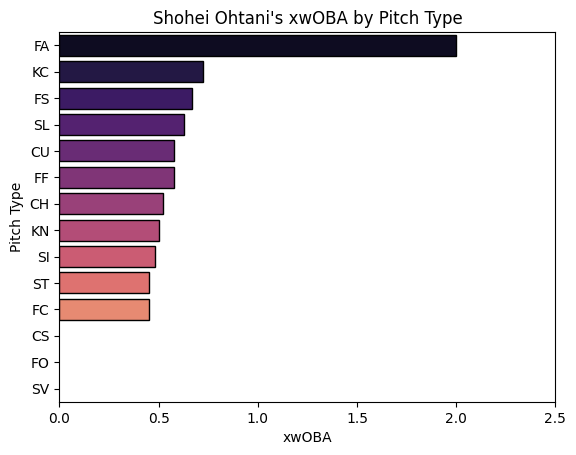

In [8]:
pitch_type_xwoba = ohtani_data.groupby("pitch_type")["estimated_woba_by_pitch_type"].mean().reset_index()
pitch_type_xwoba = pitch_type_xwoba.sort_values(by="estimated_woba_by_pitch_type", ascending=False)
sns.barplot(x="estimated_woba_by_pitch_type", y="pitch_type", data=pitch_type_xwoba, palette="magma", edgecolor="black")
plt.xlabel("xwOBA")
plt.ylabel("Pitch Type")
plt.title("Shohei Ohtani's xwOBA by Pitch Type")
plt.xlim(0, 2.5) 
plt.show()

In [9]:
pitch_data_bip = pitch_data[pitch_data["description"] == "hit_into_play"]

features = ['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'spin_axis',
            'release_extension', 'estimated_woba_using_speedangle_zone_avg', 
            'estimated_woba_by_pitch_type', 'cluster_label', 'n_thruorder_pitcher']

target = 'estimated_woba_using_speedangle'
pitch_data_clean = pitch_data_bip.dropna(subset=[target])
pitch_data_encoded = pd.get_dummies(pitch_data_clean, columns=['pitch_type'])
features = [col for col in features if col in pitch_data_encoded.columns]

X_train, X_test, y_train, y_test = train_test_split(pitch_data_encoded[features], 
                                                    pitch_data_encoded[target], test_size=0.2, random_state=4400)

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', random_state=4400)

param_grid = {'max_depth': [2, 4, 6, 8],
              'learning_rate': [0.05, 0.1, 0.2],
              'n_estimators': [100, 200, 300],
              'subsample': [0.85, 0.9, 0.95],
              'colsample_bytree': [0.6, 0.7, 0.8],
              'reg_lambda': [0.1, 1, 10],          
              'reg_alpha': [0.1, 1, 10]}

grid_search = GridSearchCV(xgb_regressor, param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best XGBoost Params: {best_params}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")

cv_scores = cross_val_score(best_model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=3)
print(f"CV RMSE: {-cv_scores.mean()} ± {cv_scores.std()}")


Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
Best XGBoost Params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'reg_alpha': 10, 'reg_lambda': 0.1, 'subsample': 0.85}
RMSE: 0.36276695387134683
MAE: 0.27334287700075377
R² Score: 0.11118722251939506
CV RMSE: 0.36373033092983803 ± 0.0009735144219170231


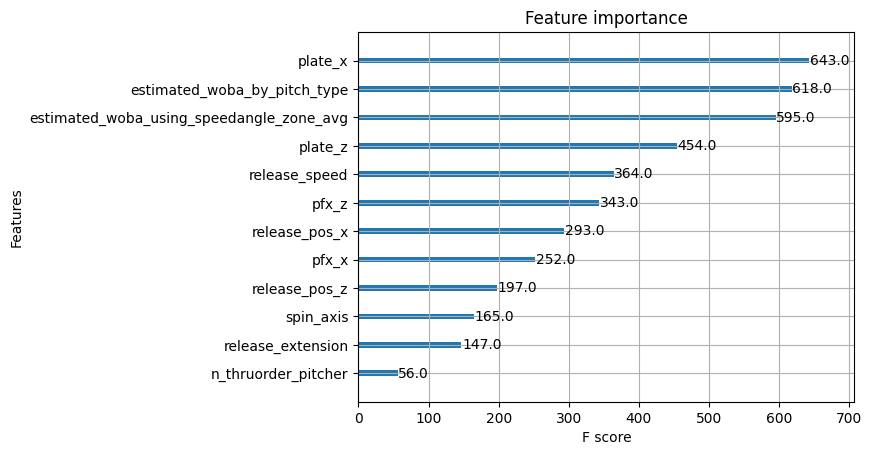

In [10]:
xgb.plot_importance(best_model, importance_type='weight', max_num_features=12)
plt.show()

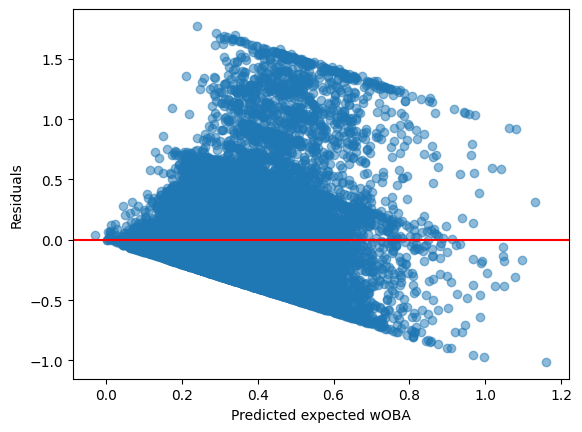

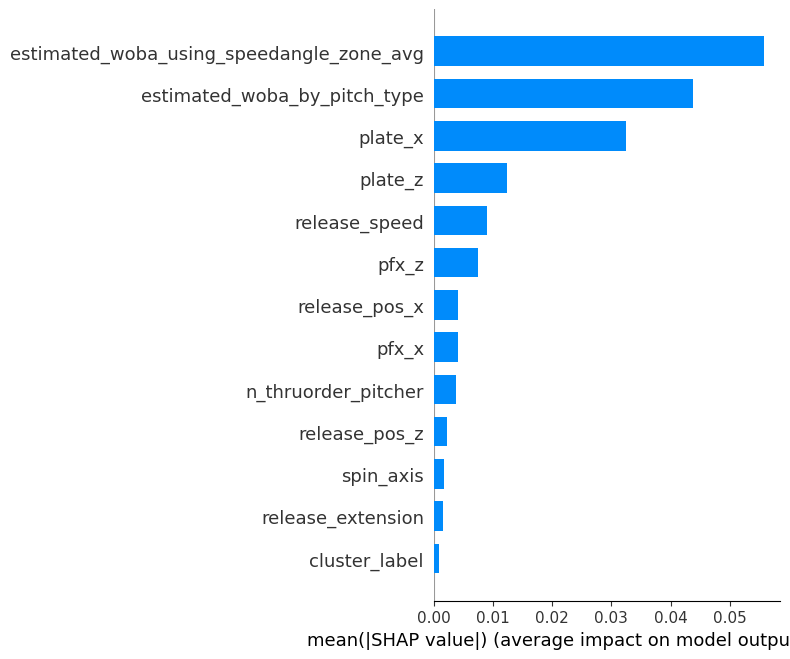

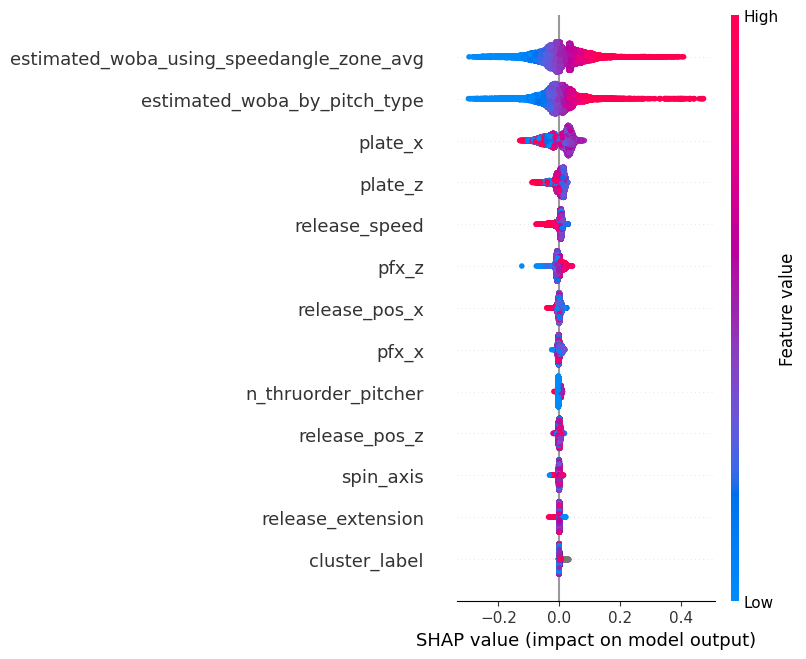

10 biggest prediction errors:
        release_speed  release_pos_x  release_pos_z  pfx_x  pfx_z  plate_x  \
310919           96.0          -0.83           5.80  -0.43   1.42    -0.72   
484455           83.0          -0.54           5.98   0.57  -0.91     0.20   
18171            90.1           1.02           5.90   0.21   1.69    -0.87   
188133           94.1           1.33           6.02   1.02   1.52     0.79   
671709           91.0          -0.76           5.95  -0.90   0.79    -0.88   
737633           96.9           1.69           6.41   0.62   1.44     0.34   
281718           94.0          -1.19           6.24   0.16   1.16    -0.81   
30478            91.8           2.26           6.02  -0.13   1.00    -0.69   
582578           94.0          -2.01           5.78  -0.49   0.99     0.44   
17331            82.2           1.59           5.60   1.55   0.59    -0.78   

        plate_z  spin_axis  release_extension  \
310919     3.61      209.0                7.7   
484455     2.

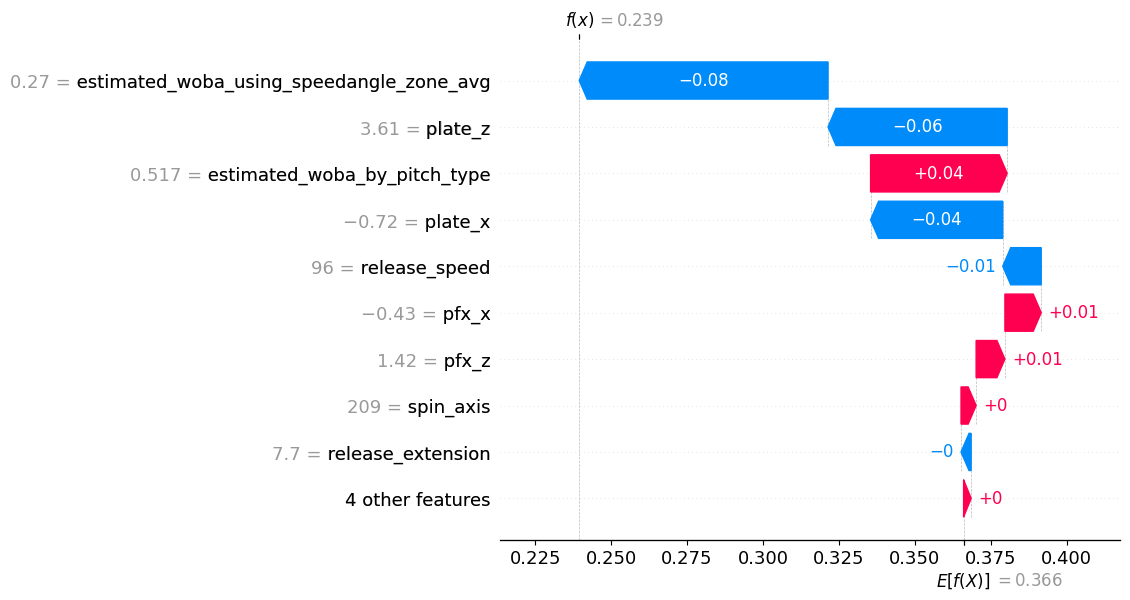

In [18]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red')
plt.xlabel("Predicted expected wOBA")
plt.ylabel("Residuals")
plt.show()

explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

error_df = X_test.copy()
error_df["actual"] = y_test
error_df["predicted"] = y_pred
error_df["error"] = abs(error_df["actual"] - error_df["predicted"])
print("10 biggest prediction errors:")
print(error_df.sort_values("error", ascending=False).head(10))

worst_index = np.argmax(np.abs(y_test - y_pred))
example = X_test.iloc[[worst_index]]
explainer = shap.Explainer(best_model)
shap_values_single = explainer(example)
shap.plots.waterfall(shap_values_single[0], max_display=10)


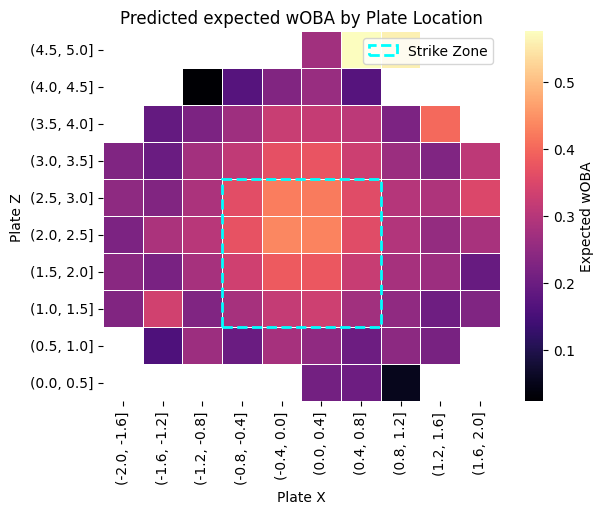

In [30]:
ax = sns.heatmap(pivot, cmap="magma", linewidths=0.5, cbar_kws={"label": "Expected wOBA"})
plt.title("Predicted expected wOBA by Plate Location")
plt.xlabel("Plate X")
plt.ylabel("Plate Z")
plt.gca().invert_yaxis()

# 10 bins from -2 to 2 in the x dimension, 10 bins from 0 to 5 in the z dimension
strike_zone = Rectangle(   #overlay the zone
    (3, 2),        
    width=4,       # spans ~ -0.83 to 0.83 for width of home plate
    height=4,      #1.5 to 3.5 for height
    linewidth=2,
    edgecolor='cyan',
    facecolor='none',
    linestyle='--',
    label='Strike Zone')
ax.add_patch(strike_zone)
plt.legend(loc='upper right')
plt.show()
